In [1]:
import torch
import torch.nn.functional as F
from torch import nn
import pandas as pd
import matplotlib.pyplot as plt
from latex import latexify, format_axes
from pprint import pprint
from sklearn.manifold import TSNE
import torch._dynamo
torch._dynamo.config.suppress_errors = True
%matplotlib inline
%config InlineBackend.figure_format = "retina"

In [ ]:
!sudo apt install cm-super dvipng texlive-latex-extra texlive-latex-recommended

In [2]:
if (torch.cuda.is_available()):
    device = torch.device("cuda")
elif (torch.backends.mps.is_available()):
    device = torch.device("mps")
else:
    device = torch.device("cpu")
print(device)

cuda


## **Tolstoy Corpus**

In [3]:
fileTolstoy = open("tolstoy.txt", "r")
tolstoy = fileTolstoy.read()
print(tolstoy[:1000])
new_tolstoy = ""
for char in tolstoy:
    if char in ['à', 'ä', 'é', 'ê']:
        continue
    new_tolstoy += char

characters = sorted(list(set(new_tolstoy)))
print(len(new_tolstoy))
print(len(characters))
print(characters)

"Well, Prince, so Genoa and Lucca are now just family estates of the
Buonapartes. But I warn you, if you don't tell me that this means war,
if you still try to defend the infamies and horrors perpetrated by that
Antichrist--I really believe he is Antichrist--I will have nothing more
to do with you and you are no longer my friend, no longer my 'faithful
slave,' as you call yourself! But how do you do? I see I have frightened
you--sit down and tell me all the news."

It was in July, 1805, and the speaker was the well-known Anna Pavlovna
Scherer, maid of honor and favorite of the Empress Marya Fedorovna. With
these words she greeted Prince Vasili Kuragin, a man of high rank and
importance, who was the first to arrive at her reception. Anna Pavlovna
had had a cough for some days. She was, as she said, suffering from la
grippe; grippe being then a new word in St. Petersburg, used only by the
elite.

All her invitations without exception, written in French, and delivered
by a scarlet-liverie

In [4]:
stoi = {s : i + 1 for i, s in enumerate(characters)}
stoi["_"] = 0
itos = {i : s for s, i in stoi.items()}
pprint(itos)

{0: '_',
 1: '\n',
 2: ' ',
 3: '!',
 4: '"',
 5: "'",
 6: '(',
 7: ')',
 8: '*',
 9: ',',
 10: '-',
 11: '.',
 12: '/',
 13: '0',
 14: '1',
 15: '2',
 16: '3',
 17: '4',
 18: '5',
 19: '6',
 20: '7',
 21: '8',
 22: '9',
 23: ':',
 24: ';',
 25: '=',
 26: '?',
 27: 'A',
 28: 'B',
 29: 'C',
 30: 'D',
 31: 'E',
 32: 'F',
 33: 'G',
 34: 'H',
 35: 'I',
 36: 'J',
 37: 'K',
 38: 'L',
 39: 'M',
 40: 'N',
 41: 'O',
 42: 'P',
 43: 'Q',
 44: 'R',
 45: 'S',
 46: 'T',
 47: 'U',
 48: 'V',
 49: 'W',
 50: 'X',
 51: 'Y',
 52: 'Z',
 53: 'a',
 54: 'b',
 55: 'c',
 56: 'd',
 57: 'e',
 58: 'f',
 59: 'g',
 60: 'h',
 61: 'i',
 62: 'j',
 63: 'k',
 64: 'l',
 65: 'm',
 66: 'n',
 67: 'o',
 68: 'p',
 69: 'q',
 70: 'r',
 71: 's',
 72: 't',
 73: 'u',
 74: 'v',
 75: 'w',
 76: 'x',
 77: 'y',
 78: 'z'}


![](./MLPToken.svg)

## Generating the Training Samples

In [5]:
block_size = 10
start = 0
X, Y = [], []
context = [0] * block_size
for idx in range(len(new_tolstoy)):
  ix = stoi[new_tolstoy[idx]]
  X.append(context)
  Y.append(ix)
  # print(''.join(itos[i] for i in context), '--->', itos[ix])
  context = context[1:] + [ix]

X = torch.tensor(X).to(device)
Y = torch.tensor(Y).to(device)

In [6]:
X.shape, Y.shape

(torch.Size([3196195, 10]), torch.Size([3196195]))

In [7]:
# Embedding layer for the context
emb_dim = 15
emb = torch.nn.Embedding(len(stoi), emb_dim)

In [8]:
emb.weight.shape

torch.Size([79, 15])

## Function to visualize the embedding in 2d space using **t-SNE**

<Axes: >

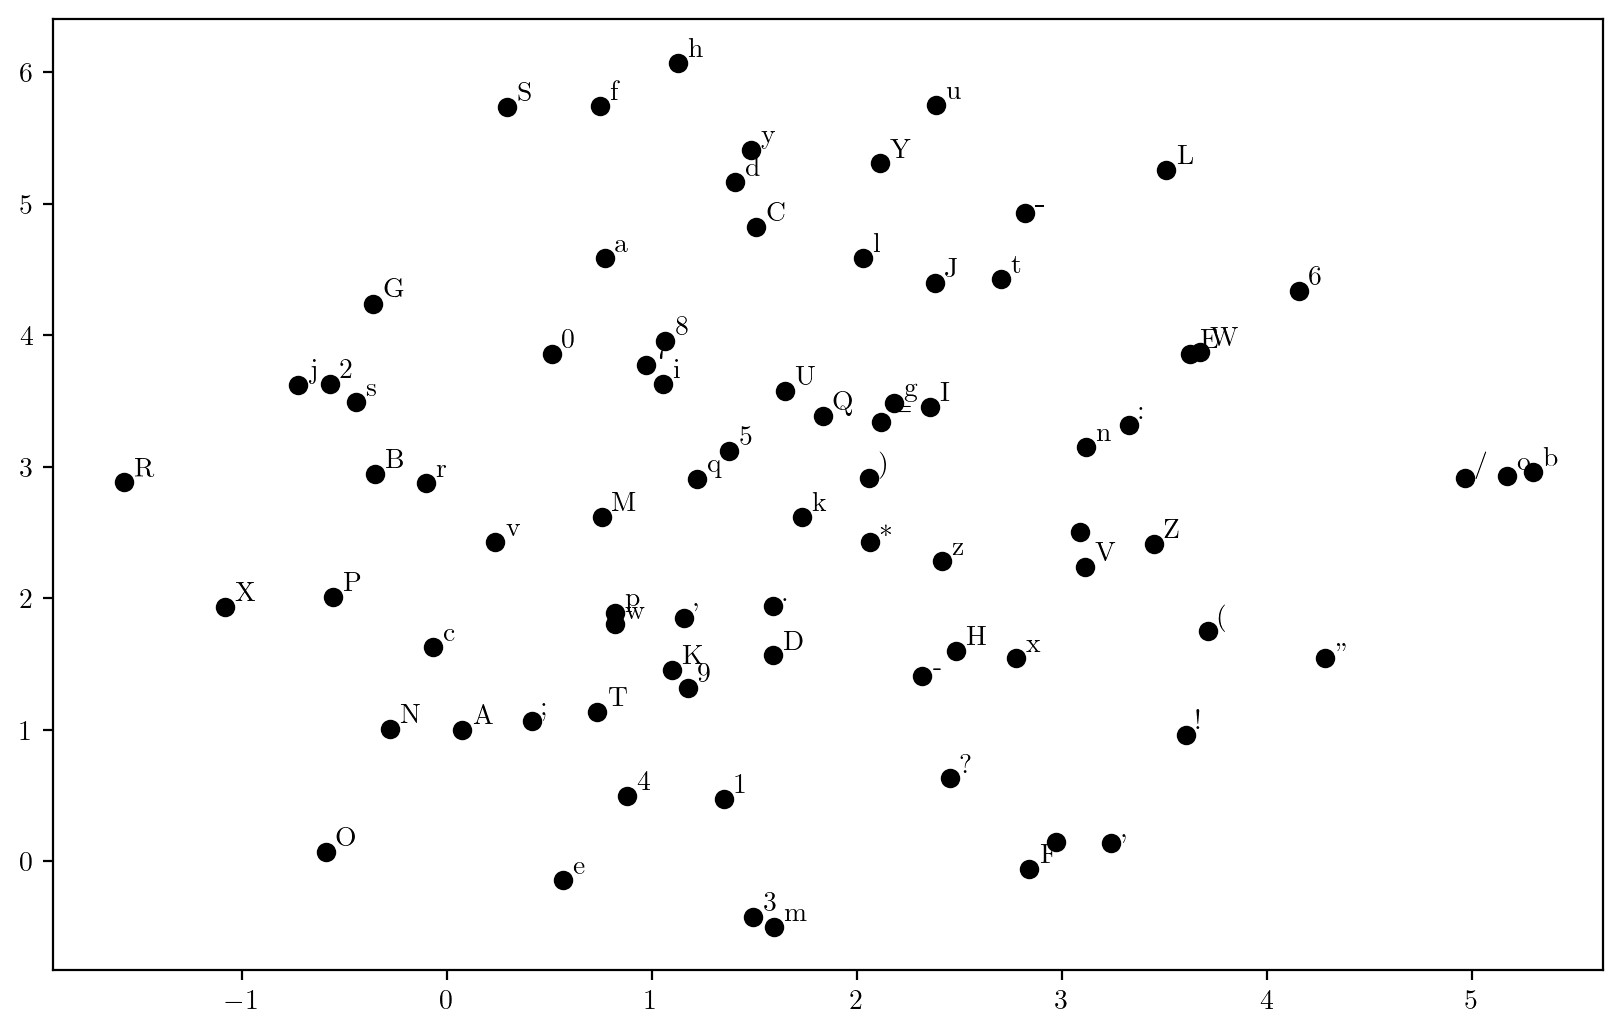

In [9]:
latexify(columns = 2, fig_width = 10)
def plot_emb(emb, itos, ax=None):
    if emb.weight.shape[1] != 2:
      tsne = TSNE(n_components = 2)
      emb_new = tsne.fit_transform(emb.weight.detach().cpu().numpy())
    if ax is None:
        fig, ax = plt.subplots()
    for i in range(len(itos)):
        if emb.weight.shape[1] == 2:
          x, y = emb.weight[i].detach().cpu().numpy()
          ax.scatter(x, y, color='k')
          ax.text(x + 0.05, y + 0.05, itos[i])
        else:
          x, y = emb_new[i]
          ax.scatter(x, y, color = 'k')
          ax.text(x + 0.05, y + 0.05, itos[i])
    return ax

plot_emb(emb, itos)

## Structure of the **MLP**

![Alt](./Embed.svg)
![Alt](./ModelEmbed.svg)

In [10]:
class NextChar(nn.Module):
  def __init__(self, block_size, vocab_size, emb_dim, hidden_size):
    super().__init__()
    self.emb = nn.Embedding(vocab_size, emb_dim)
    self.lin1 = nn.Linear(block_size * emb_dim, hidden_size)
    self.lin2 = nn.Linear(hidden_size, vocab_size)

  def forward(self, x):
    x = self.emb(x)
    x = x.view(x.shape[0], -1)
    x = torch.tanh(self.lin1(x))
    x = self.lin2(x)
    return x

In [11]:
model = NextChar(block_size, len(stoi), emb_dim, 30).to(device)
model = torch.compile(model)

In [12]:
for param_name, param in model.named_parameters():
    print(param_name, param.shape)

_orig_mod.emb.weight torch.Size([79, 15])
_orig_mod.lin1.weight torch.Size([30, 150])
_orig_mod.lin1.bias torch.Size([30])
_orig_mod.lin2.weight torch.Size([79, 30])
_orig_mod.lin2.bias torch.Size([79])


## Generating names from untrained model

In [15]:
import warnings
warnings.filterwarnings("ignore")

g = torch.Generator()
g.manual_seed(42)
def generate_text(model, itos, stoi, block_size, max_len, start_str = None):

    context = [0] * block_size
    if start_str:
        for s in start_str:
            context = context[1:] + [stoi[s]]
    text = start_str if start_str else ""
    for i in range(max_len):
        x = torch.tensor(context).view(1, -1).to(device)
        y_pred = model(x)
        ix = torch.distributions.categorical.Categorical(logits = y_pred).sample().item()
        ch = itos[ix]
        text += ch
        context = context[1:] + [ix]
    return text

generate_text(model, itos, stoi, block_size, 1000, "This is ")

'This is LfPr3ej_.,;HshG-2Q*Cr7cdrC8*hHB)HNVqfO4e()jXjb!w,Mrxh,feH=\n/OX=IG3DJgXl67,QlJKlpf1"C3Ri.ve(CZ5-YFr5-nuD"Zm/ovIlO4DZ277oA*5AQ:")T-2qy9sAAIm.u="cHe(7ty!7Y*p;AT0;Lu.rv-SgsTOTxE6g_n _nhsvI_GeRaiALw\'.YJ"xIXfKQ ! ZbkAbYv.5EiCYgR9eIY;KOUij0Z7rSL\n7.s0I!=ZTv0f9Z29=56pByU2I\n?=9j(nETDm:7h_brz4SDH=5uicLt,HHBd9P=CoXcsHQ;?!D0k(jpx.B-ETHyuBdLqT2HsO:=6X60iza0FFZ(?x)H!mH:tSETLObjhMUWR\',T*iD)0)Z?(/ZkRGiI!\'S!*aqGad3IzQ-xPX9GeXpzs:bvypOK*sShvdSM5h3e5K)o9k0rjHD8T-B2C?MqdXl1\'TMIC.C!ot2A6EZiTD(6\'45Bc1A""S=0lBHf"uiyJFyR;"Ytm"b8;1?SZe2Iq1\'(yTQE5DL;bz*cJmvkuoA0\nFrrm4:sF(v/Btb.C3L\'f98.fa"X3k;rA-3DZpdTT"18)6CFXzdylc_";GVcFN:!Fsw5Q"J\':xLjk;2EX\nLnhzTGOk\':-_)RJwku=GKsJ-AwTq( \'E83ZzJ_T.8m\'z_,ML=Fm,JO2l:0aKD"Ue.DvR0qt;AO3g(e3"f"!Y;aM\'Bs3=SC*bNxyg"_qM)Ie3mzXFiQ/jqBh3\',P\nVy7D*LdfA3q*OJYbPF.!wqfpvYfN3XYI./3*28:C=JP3bNM2U1G/ CGqlW\n?XqoRzn:qUM/CBDpi.WG?j0G-_-KbtS!pV _F,f4yYJBGAsq!T7:ij;zw8ZnKgj6 RzLW?97*jKra"c?Oaw.3Wg/=ny/ "\n 2j6Uir)b!rJD/XM4T 29:3_9nRN!uHnM2\n/Z:lwdE(sxDX-mNx3F\'Iq"2SoHKKt=8g

## Model Training

In [16]:
loss_fn = nn.CrossEntropyLoss()
opt = torch.optim.AdamW(model.parameters(), lr = 0.01)
batch_size = 4096
print_every = 100
for epoch in range(10000):
  for i in range(0, X.shape[0], batch_size):
      x = X[i : i + batch_size]
      y = Y[i : i + batch_size]
      y_pred = model(x)
      loss = loss_fn(y_pred, y)
      loss.backward()
      opt.step()
      opt.zero_grad()
  if epoch % print_every == 0:
    print(epoch, loss.item())

0 1.9561831951141357
100 1.9306466579437256
200 1.9300551414489746
300 1.9343842267990112
400 1.8965063095092773


KeyboardInterrupt: 

## **Saving the model**

In [17]:
torch.save(model.state_dict(), "model.pth")

In [18]:
model.state_dict()

OrderedDict([('_orig_mod.emb.weight',
              tensor([[ 5.0615e-01, -5.6892e-01,  7.5416e-01,  ...,  6.8933e-02,
                       -3.2933e-01, -8.3778e-01],
                      [ 4.9799e-02,  3.4271e-01, -2.5005e-02,  ..., -1.2674e-01,
                        8.3871e-02, -3.3985e+00],
                      [ 1.5629e-01, -1.6611e-01,  3.2039e-03,  ..., -8.6060e-02,
                       -5.6141e-02, -3.5420e+00],
                      ...,
                      [ 4.3637e-01,  4.1607e-01, -1.5563e-01,  ..., -1.2166e+00,
                        2.0742e-01,  6.5734e-01],
                      [ 1.2309e+00, -1.6770e-01,  9.7409e-01,  ..., -1.3490e-01,
                        2.2377e-01,  5.5039e-01],
                      [ 5.6302e-01, -1.6076e-01,  3.7211e-01,  ..., -5.6001e-01,
                        5.3801e-01,  6.5302e-01]], device='cuda:0')),
             ('_orig_mod.lin1.weight',
              tensor([[-9.7887e-02, -4.4552e-02, -4.5607e-02,  ...,  4.3644e-02,
         

## **Loading the model**

In [25]:
if (torch.cuda.is_available()):
    device = torch.device("cuda")
elif (torch.backends.mps.is_available()):
    device = torch.device("mps")
else:
    device = torch.device("cpu")

model = NextChar(block_size, len(stoi), emb_dim, 30)
model.load_state_dict(torch.load("model.pth", map_location = device), strict = False)
model = model.to(device)
model.eval()

NextChar(
  (emb): Embedding(79, 15)
  (lin1): Linear(in_features=150, out_features=30, bias=True)
  (lin2): Linear(in_features=30, out_features=79, bias=True)
)

## Visualize the Learnt Embedding

<Axes: >

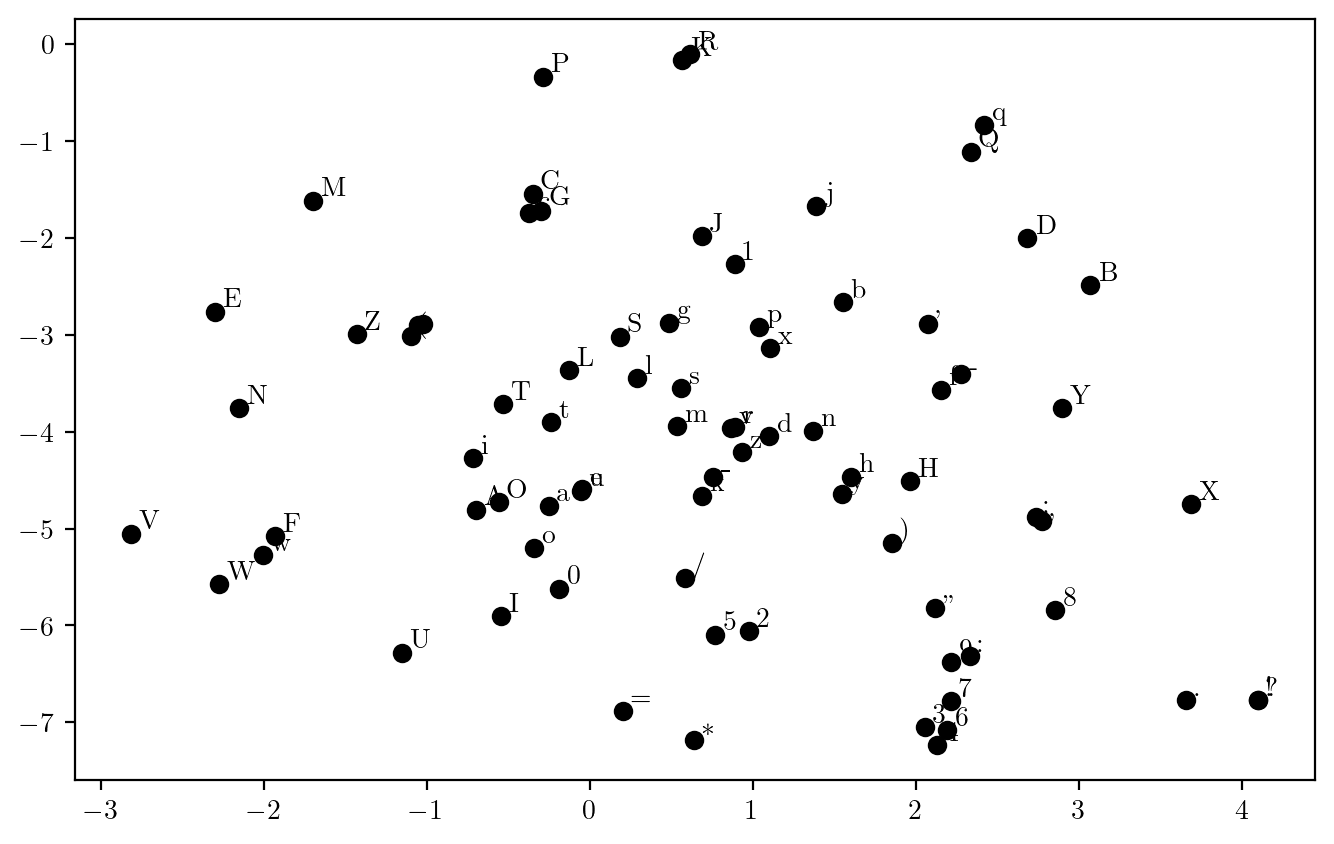

In [19]:
latexify(columns = 2, fig_width = 8)
plot_emb(model.emb, itos)

## Generating Strings from the Model

In [35]:
my_str = generate_text(model, itos, stoi, block_size, 1000, "It was the year 2024, we had an ML assignment ")
decoded_string = bytes(my_str, "utf-8").decode("unicode_escape")
print(decoded_string)

It was the year 2024, we had an ML assignment of his and thear the fees bets the Russian spochered but regons be and had
would loing part was fatk undik, is for his shad reved touted, desoit siglod wanl
began, fathelly for the. 
"What som Tirft pits from the
mole, ral chikhness cole of the
kits dure hay ammman decting?"

Tteres herry He wousen-stiendering
they her, whits and out Petron.

Turrenchs a the grany his arn
Karoun-she coars to plald time ther hanantnat an', ill matinen conderid
am thacasbeledes.

"In't in come, dut dequeomed own encalloe soud paptlard in biyto conse plewoown, not and and chan picioner mell, swe
dehlone thay yards aroughovep nons aruls, nowher harces four voom--meach bousen weant suddenskiur that as staes see
oldessh scung see ment Rostov.

Whevanie all the rught in ut and evilled
chas it who prelfore so" and frowen interurne to bether.

Howd ont antate way farly in owt werqueossal her lagono
wuided or thought Rostovher anrl was exsues strear to of it say of t